## Goal: parse the Ehux significantly regulated genes as per RSEM

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import glob
import palettable as pal
import numpy as np
import cPickle as cpk
from itertools import combinations

mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['font.sans-serif']='Arial'
%matplotlib inline


In [2]:
gFHash=cpk.load(open('../orthoMCL_output/Ehux_Dictionary.pickle', 'r'))
    

In [61]:
OG_to_Gene_Dict=cpk.load(open('../orthoMCL_output/Ehux_Dictionary.pickle', 'r'))

In [3]:
Hist_PD=pd.DataFrame(index=gFHash.keys(),columns=['NumGenes', 'Emi374', 'Emi379', 'Emi370', 'Emi219', 'Emihu1'])
Hist_PD=Hist_PD.fillna(0)
for i,key in enumerate(gFHash):
#     if i==100:
#         break
    l=len(gFHash[key])
    Hist_PD.loc[key, 'NumGenes']=l
    for transcript in gFHash[key]:
        org=transcript.split('|')[0]
        Hist_PD.loc[key,org]+=1

GenesInOrg={}
GenesInOrg['Emi219']=Hist_PD[Hist_PD.Emi219>0].index
GenesInOrg['Emi379']=Hist_PD[Hist_PD.Emi379>0].index
GenesInOrg['Emi370']=Hist_PD[Hist_PD.Emi370>0].index
GenesInOrg['Emi374']=Hist_PD[Hist_PD.Emi374>0].index
GenesInOrg['Emihu1']=Hist_PD[Hist_PD.Emihu1>0].index
def Calculate_Venn_comparison(hash):
        #input = a Hash of the form hash[Organism]=list of orthologus groups
        #Outputs a hash of the form key = all the variations of thes sets : list of orthologus genes in an inclusive way
        #It is inclusive so the set containing A uniq genes is going to contain all the genes for an org
        variations={}
        for i in range(len(hash)):
            for v in combinations(hash.keys(), i+1):
                vsets = [hash[x] for x in v]
                variations[tuple(sorted(v))]=reduce(lambda x,y: x.intersection(y), vsets)
        return variations
    
def GetDifference_Venn(variations):
    #Function takes the input from the above function and outputs a hash of the same format but 
    #each set is uniqe: e.g. there are no repeats of orthologus groups across sets. 
    outdict={}
    vkeys=variations.keys()
    #loop over each of the variable cases
    for v in variations:
        #create a set to do the comparisons
        vset=set(v)
        vdata_set=set(variations[v])
        #loop over all other variations
        for j in variations:
            #if v is a subset of jset we want to remove the items of jset from v set
            jdata_set=set(variations[j])
            jset=set(j)
            if vset.issubset(jset):
                if vset==jset:
                    pass
                else: 
                    newdata=vdata_set-jdata_set
                    vdata_set=newdata
        outdict[v]=vdata_set
    return outdict

#Get the genes that are unique with in the venn: format of the hash = name of the subset : Orthologus gene groups
Genes_In_Each_Cat=Calculate_Venn_comparison(GenesInOrg)
Genes_Uniq_Venn=GetDifference_Venn(Genes_In_Each_Cat)

In [4]:
##Import the RSEM Files for gene families
files=glob.glob("edgeR.18185.dir/*DE_results")
RSEM_Gene_Hash={}
for f in files:
    name=f.split('.')[5]
    out=pd.read_table(f)
    RSEM_Gene_Hash[name]=out

In [5]:
test=RSEM_Gene_Hash['Q_con_vs_R_PlusN']

RSEM_Gene_Stats=pd.DataFrame(index=RSEM_Gene_Hash.keys(), columns=['Total', 'DE'])
for key in RSEM_Gene_Hash.keys():
    total=len(RSEM_Gene_Hash[key])
    DE=len(RSEM_Gene_Hash[key][RSEM_Gene_Hash[key]['FDR']<0.05])
    RSEM_Gene_Stats.loc[key,:]=[total, DE]

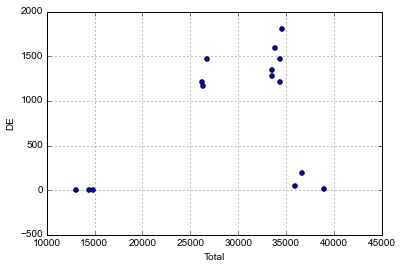

In [6]:
RSEM_Gene_Stats['DE']/RSEM_Gene_Stats['Total']
fig,ax=plt.subplots(1)
RSEM_Gene_Stats.plot(kind='scatter', x='Total', y='DE', ax=ax)
### LOoks like the plots cluster together based on what is being compared!  Prettttttyy cool. 

Q_con_vs_T_MinusN
Q_con_vs_V_MinusP
Q_con_vs_R_PlusN
Q_con_vs_S_PlusP
Q_con_vs_X_PlusDSW


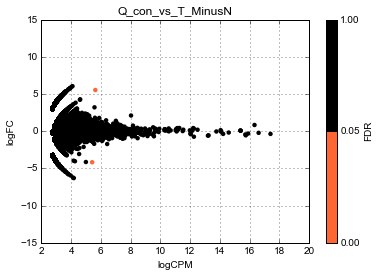

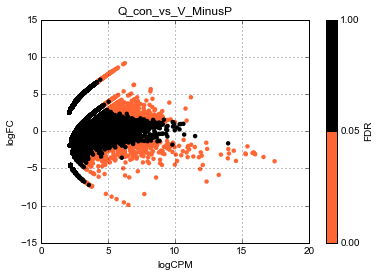

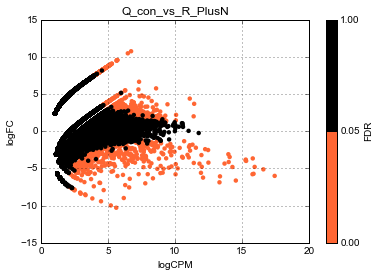

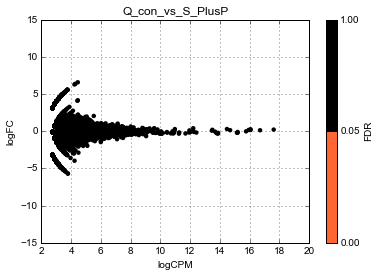

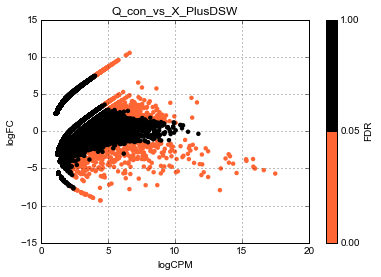

In [7]:
##Plot genes that are significant based on 0.05 FDR in comparisons with Q

cmap = plt.cm.gray_r
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (1,.4,.2,1.0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = (0,0.05,1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


for key in RSEM_Gene_Hash.keys():
    if 'Q' in key:
        ax=RSEM_Gene_Hash[key].plot(kind='scatter', x='logCPM', y='logFC',c='FDR',cmap=cmap, norm=norm, lw=0, ylim=[-15,15])
        
        ax.set_title(key)

        print(key)

In [10]:
for key in RSEM_Gene_Hash.keys():
    if 'Q' in key:
        a=RSEM_Gene_Hash[key].FDR<0.05
        up=RSEM_Gene_Hash[key].logFC>0
        dn=RSEM_Gene_Hash[key].logFC<0
        GeneList=RSEM_Gene_Hash[key][a].index

        GeneListUP=RSEM_Gene_Hash[key][a&up].index
        GeneListDN=RSEM_Gene_Hash[key][a&dn].index
        filename=key+'.csv'
        f=open(filename, 'w')
        f.write('\n'.join(GeneList))
        filename=key+'UP.csv'
        f=open(filename, 'w')
        f.write('\n'.join(GeneListUP))
        filename=key+'DN.csv'
        f=open(filename, 'w')
        f.write('\n'.join(GeneListDN))

In [11]:
files=glob.glob("edgeR.18268.dir/*DE_results")
RSEM_Transcript_Hash={}
for f in files:
    name=f.split('.')[5]
    out=pd.read_table(f)
    RSEM_Transcript_Hash[name]=out

In [12]:
test=RSEM_Gene_Hash['Q_con_vs_R_PlusN']

RSEM_Transcript_Stats=pd.DataFrame(index=RSEM_Gene_Hash.keys(), columns=['Total', 'DE'])
for key in RSEM_Transcript_Hash.keys():
    total=len(RSEM_Transcript_Hash[key])
    DE=len(RSEM_Transcript_Hash[key][RSEM_Transcript_Hash[key]['FDR']<0.05])
    RSEM_Transcript_Stats.loc[key,:]=[total, DE]

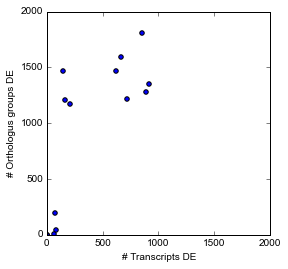

In [13]:
fig,ax=plt.subplots(1)
ax.set_aspect('equal')
ax.scatter(RSEM_Transcript_Stats['DE'], RSEM_Gene_Stats['DE'])
ax.set_xlim([0,2000])
ax.set_ylim([0,2000])
ax.set_xlabel('# Transcripts DE')
ax.set_ylabel('# Orthologus groups DE')

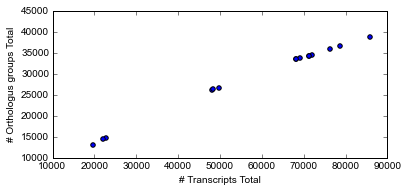

In [14]:
fig,ax=plt.subplots(1)
ax.set_aspect('equal')
ax.scatter(RSEM_Transcript_Stats['Total'], RSEM_Gene_Stats['Total'])
ax.set_xlabel('# Transcripts Total')
ax.set_ylabel('# Orthologus groups Total')

In [15]:
for name in RSEM_Transcript_Stats.index:
    RSEM_Transcript_Stats.loc[name,'Con1']=name.split('_')[0]
    RSEM_Transcript_Stats.loc[name,'Con2']=name.split('_')[3]
    RSEM_Gene_Stats.loc[name,'Con1']=name.split('_')[0]
    RSEM_Gene_Stats.loc[name,'Con2']=name.split('_')[3]

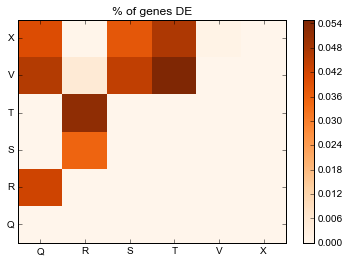

In [16]:
def PlotHeatmap(df,df2=None, ax=None):
    if ax ==None:
        fig,ax = plt.subplots(1)
    exps=['Q','R','S','T','V', 'X']
    hm=pd.DataFrame(index=exps, columns=exps,dtype='float')
#     for i,ex in enumerate(exps):
#         for j,ex2 in enumerate(exps):
#             print df[((df['Con1']==i)&(df['Con2']==j))]
# #             hm.loc[i,j]=
    df=df.sort(['Con1', 'Con2'])
    for i in df.index:
        ci=df.loc[i,'Con1']
        cr=df.loc[i,'Con2']
        hm.loc[cr,ci]=float(df.loc[i,'DE'])/float(df.loc[i,'Total'])
    if df2!=None:

        for i in df2.index:
            cr=df2.loc[i,'Con1']
            ci=df2.loc[i,'Con2']
            hm.loc[cr,ci]=df2.loc[i,'DE']
    hm=hm.astype('float')
    hm=hm.fillna(0)
    cplot=ax.pcolor(hm,cmap=pal.colorbrewer.sequential.Oranges_9.get_mpl_colormap())
    ax.set_xticks(np.arange(0.5,5.6, 1))
    ax.set_yticks(np.arange(0.5,5.6, 1))
    ax.set_yticklabels(exps)
    ax.set_xticklabels(exps)
    cbar=fig.colorbar(cplot)
    ax.set_title('% of genes DE')
PlotHeatmap(RSEM_Gene_Stats)


## Look at the gene content within genes that are DE with N addition

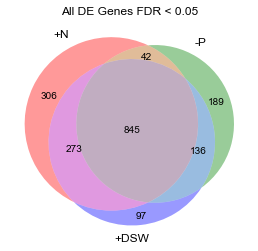

In [30]:
#All differentially regulated genes
from matplotlib_venn import venn3

QR=RSEM_Gene_Hash['Q_con_vs_R_PlusN']
QV=RSEM_Gene_Hash['Q_con_vs_V_MinusP']
QX=RSEM_Gene_Hash['Q_con_vs_X_PlusDSW']

QR_Sig_Set=set(QR[QR.FDR<0.05].index)
QV_Sig_Set=set(QV[QV.FDR<0.05].index)
QX_Sig_Set=set(QX[QX.FDR<0.05].index)

fig,ax=plt.subplots(1)
venn3([QR_Sig_Set, QV_Sig_Set, QX_Sig_Set], set_labels=['+N','-P', '+DSW'],ax=ax)
ax.set_title('All DE Genes FDR < 0.05')

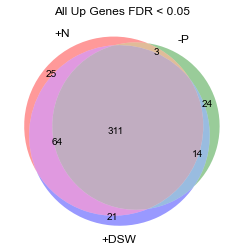

In [31]:
Up_R_Q=set(QR[(QR.FDR<0.05)&(QR.logFC<0)].index)
Up_V_Q=set(QV[(QV.FDR<0.05)&(QV.logFC<0)].index)
Up_X_Q=set(QX[(QX.FDR<0.05)&(QX.logFC<0)].index)

fig,ax=plt.subplots(1)
venn3([Up_R_Q, Up_V_Q, Up_X_Q], set_labels=['+N','-P', '+DSW'])
ax.set_title('All Up Genes FDR < 0.05')

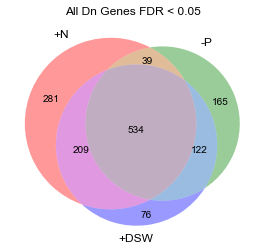

In [32]:
Dn_R_Q=set(QR[(QR.FDR<0.05)&(QR.logFC>0)].index)
Dn_V_Q=set(QV[(QV.FDR<0.05)&(QV.logFC>0)].index)
Dn_X_Q=set(QX[(QX.FDR<0.05)&(QX.logFC>0)].index)

fig,ax=plt.subplots(1)
venn3([Dn_R_Q, Dn_V_Q, Dn_X_Q], set_labels=['+N','-P', '+DSW'])
ax.set_title('All Dn Genes FDR < 0.05')

### Look at distribution of the genes across different functional groups

In [40]:
def invertDict(inhash):
    #Invert the key/value pairs in a dictionary
    outhash={}
    for key in inhash:
        for value in inhash[key]:
            outhash[value]=key
    return outhash
Genes_Uniq_Venn_inv=invertDict(Genes_Uniq_Venn)

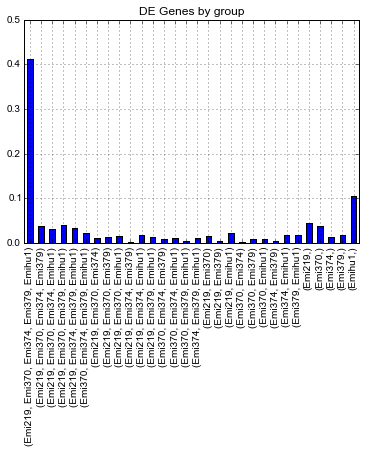

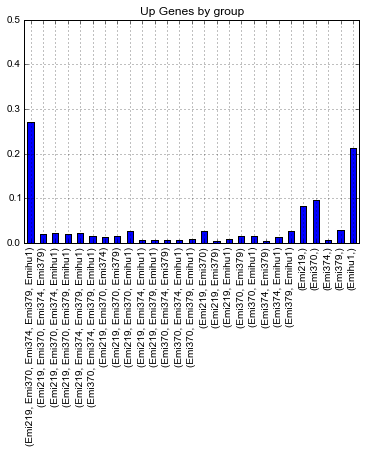

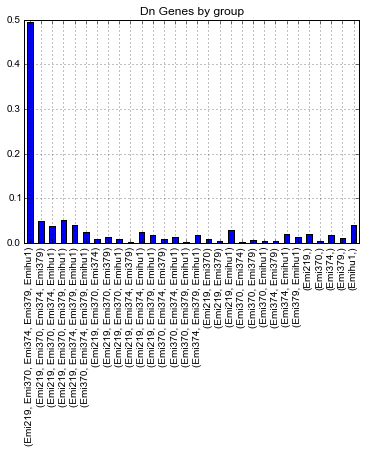

In [95]:
def ParseOG(inhash):
    #Loop through a given hash of genes and determine where it falls by group via the defined orthologus gene hash 
    OG_InSet={}
    OG_InList={}
    for og in inhash:
        s=Genes_Uniq_Venn_inv[og]
        if s in OG_InSet.keys():
            OG_InSet[s]+=1
            OG_InList[s].append(og)
        else: 
            OG_InSet[s]=1
            OG_InList[s]=[og]
    out_PD=pd.DataFrame.from_dict(OG_InSet,orient='index')
    out_PD=out_PD/out_PD.sum()
    xs=out_PD.index
    xs=list(xs)
    xs.sort()
    xs.sort(key = lambda s: len(s), reverse=True)
    out_PD=out_PD.loc[xs]
    #returns panda dict with relative percentages of representation and a hash of OGs in each of the groupings
    return (out_PD, OG_InList)

Sig_By_EhxVen, Sig_OGInList=ParseOG((QR_Sig_Set.intersection(QV_Sig_Set)).intersection(QX_Sig_Set))
Up_By_EhxVen, Up_OGInList=ParseOG((Up_R_Q.intersection(Up_V_Q)).intersection(Up_X_Q))
Dn_By_EhxVen, Dn_OGInList=ParseOG((Dn_R_Q.intersection(Dn_V_Q)).intersection(Dn_X_Q))
Dn_union_By_EhxVen, Dn_union_OGInList=ParseOG((Dn_R_Q.union(Dn_V_Q)).union(Dn_X_Q))

Sig_By_EhxVen.plot(kind='bar', legend=False, title='DE Genes by group', ylim=[0,0.5])
Up_By_EhxVen.plot(kind='bar', legend=False, title='Up Genes by group', ylim=[0,0.5])
Dn_By_EhxVen.plot(kind='bar', legend=False, title='Dn Genes by group', ylim=[0,0.5])


In [97]:


Dn_OGInList_genes={}
c=0
for OG in Dn_OGInList[('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1')]:
    c+=1
    geneList=OG_to_Gene_Dict[OG]
    matching = [s for s in geneList if "Emihu1" in s]
    UP_R_Unique_Genes[OG]=matching
    print OG,';', ' '.join(UP_R_Unique_Genes[OG])
print c

OG1_5_1543 ; Emihu1|443184
OG1_5_1228 ; Emihu1|459441 Emihu1|108927
OG1_5_8300 ; Emihu1|355518
OG1_5_5853 ; Emihu1|432789
OG1_5_6816 ; Emihu1|415365
OG1_5_7233 ; Emihu1|437026
OG1_5_4106 ; Emihu1|351475
OG1_5_4108 ; Emihu1|441117
OG1_5_7729 ; Emihu1|452176
OG1_5_5752 ; Emihu1|369425
OG1_5_6330 ; Emihu1|441629
OG1_5_7798 ; Emihu1|310078
OG1_5_4583 ; Emihu1|117831 Emihu1|204066
OG1_5_8376 ; Emihu1|440222
OG1_5_4539 ; Emihu1|442968 Emihu1|352634
OG1_5_6631 ; Emihu1|237054
OG1_5_4536 ; Emihu1|468436
OG1_5_7330 ; Emihu1|236632
OG1_5_2360 ; Emihu1|459683 Emihu1|470487
OG1_5_8054 ; Emihu1|453525
OG1_5_3466 ; Emihu1|455418 Emihu1|365287
OG1_5_6592 ; Emihu1|432696
OG1_5_4249 ; Emihu1|435434
OG1_5_7996 ; Emihu1|108485
OG1_5_3861 ; Emihu1|464758 Emihu1|450495
OG1_5_3382 ; Emihu1|444355 Emihu1|436758
OG1_5_3381 ; Emihu1|252364 Emihu1|110592
OG1_5_2700 ; Emihu1|432191
OG1_5_8023 ; Emihu1|414681
OG1_5_8453 ; Emihu1|207479
OG1_5_8450 ; Emihu1|438674
OG1_5_5815 ; Emihu1|453191
OG1_5_1009 ; Emihu1|3740

In [67]:
UP_Unique_Genes={}
for OG in Up_OGInList[('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1')]:
    geneList=OG_to_Gene_Dict[OG]
    matching = [s for s in geneList if "Emihu1" in s]
    UP_Unique_Genes[OG]=matching

In [70]:
#write out the upregulated genes that are common to all strains. 
fout=open('OG_Upregulated_AllStrains_Emihu1.tab','w')
for key in UP_Unique_Genes.keys():
    fout.write(key)
    fout.write('\t')
    fout.write(' '.join(UP_Unique_Genes[key]))
    fout.write('\n')

fout.close()

In [19]:
KAAS_Hash={}
for line in open('../TranscriptomeAnnotation/KAAS_Ehux_Protein_Annotation.tab', 'r'):
    line=line.split()
    if len(line)>1:
        KAAS_Hash[line[0].strip()]=line[1].strip()
    else:
        KAAS_Hash[line[0].strip()]=None

        
#Relate KEGG to OGs
newOG_KEGGHash={}
for gene in gFHash:
    newOG_KEGGHash[gene]=[]
    for transcript in gFHash[gene]:
        kegg=KAAS_Hash[transcript]
        if kegg in newOG_KEGGHash[gene]:
            pass
        elif kegg==None:
            pass
        else: 
            newOG_KEGGHash[gene].append(kegg)#


#Read in ko00002 table
Kegg_masterDict_ko0002={}
file=open('../TranscriptomeAnnotation/ko00002_table.tab', 'r')
header=next(file)
header= header.split('\t')
for l in file:
    line=l.split('\t')
    kegg=line[0]
    a={}
    for i,e in enumerate(line):
        a[header[i]]=e
    Kegg_masterDict_ko0002[kegg]=a


In [22]:
#Look at the KEGG ID of Up_Intersection
Up_Intersection=(Up_R_Q.intersection(Up_V_Q)).intersection(Up_X_Q)
UP_KEGG=[]

for OG in Up_Intersection:
    if OG in newOG_KEGGHash.keys():
        UP_KEGG.append(newOG_KEGGHash[OG])
        
UP_KEGG=[item for sublist in UP_KEGG for item in sublist]


Dn_Intersection=(Dn_R_Q.intersection(Dn_V_Q)).intersection(Dn_X_Q)
DN_KEGG=[]

for OG in Dn_Intersection:
    if OG in newOG_KEGGHash.keys():
        DN_KEGG.append(newOG_KEGGHash[OG])
        
DN_KEGG=[item for sublist in DN_KEGG for item in sublist]

In [23]:
#Read in KOG table and create a dictionary of dictionaries to describe all the data. 
KOG_MasterDict={}
file=open('../TranscriptomeAnnotation/KOG/output/output.2', 'r')
header=next(file)
header= header.split('\t')
for l in file:
    line=l.split('\t')
    PID=line[0]
    a={}
    for i,e in enumerate(line):
        a[header[i].strip()]=e.strip()
    KOG_MasterDict[PID]=a
KOG_MasterDict

##Create a pandas DF from the master dict and adjust it

KOG_MasterPD=pd.DataFrame.from_dict(KOG_MasterDict, orient='columns').T

In [24]:
def invert(d):
    return dict( (v,k) for k in d for v in d[k] )
    
gFHash_inverted=invert(gFHash)

KOG_MasterPD=KOG_MasterPD.loc[gFHash_inverted.keys()]
KOG_MasterPD['Organism']=[item.split('|')[0] for item in KOG_MasterPD.index]
KOG_MasterPD['OrthoMCLGroups']=KOG_MasterPD['#Query'].map(gFHash_inverted)
KOG_MasterPD=KOG_MasterPD.dropna()


In [ ]:
fig,ax=plt.subplots(1)
fig.set_size_inches(10,8)
KOG_MasterPD_OG=KOG_MasterPD.set_index('OrthoMCLGroups')
UpGenes_KOG=KOG_MasterPD_OG.loc[Up_Intersection].dropna()
UP_KOG_Class=UpGenes_KOG.groupby('class').size()
for ind in UP_KOG_Class.index:
    if len(ind)>1:
        UP_KOG_Class=UP_KOG_Class.drop(ind)
        

DnGenes_KOG=KOG_MasterPD_OG.loc[Dn_Intersection].dropna()
DN_KOG_Class=DnGenes_KOG.groupby('class').size()
for ind in DN_KOG_Class.index:
    if len(ind)>1:
        DN_KOG_Class=DN_KOG_Class.drop(ind)
        
DE_Reg_Intersetion=pd.DataFrame(UP_KOG_Class,columns=['UP'])
DE_Reg_Intersetion['DN']=DN_KOG_Class

DE_Reg_Intersetion.plot(kind='bar', lw=0,
                        colormap=pal.colorbrewer.diverging.PRGn_4.get_mpl_colormap(), ax=ax, grid=False)

In [58]:
py.sign_in('halexand', 'ox16mvkj4g')

In [98]:
import plotly.plotly as py
from plotly.graph_objs import *
df = RSEM_Gene_Hash['Q_con_vs_R_PlusN']
df = df.join(KOG_MasterPD.set_index('OrthoMCLGroups'), how='outer')

dn = df.logFC < 0
up = df.logFC > 0 
sig = df.FDR < 0.05

PDSigUp = df[up & sig]
PDSigDn = df[dn & sig]

df.head(2)

fig = {
    'data': [
  		{
  			'x': PDSigUp.logCPM , 
        	'y': PDSigUp.logFC, 
        	'text': PDSigUp.index + ': ' + PDSigUp.description, 
        	'mode': 'markers', 
        	'name': 'UP Regulated'},
        {
        	'x': PDSigDn.logCPM, 
        	'y': PDSigDn.logFC, 
        	'text': PDSigDn.index + ': ' + PDSigDn.description, 
        	'mode': 'markers', 
        	'name': 'DN Regulated'}
    ],
    'layout': {
        'xaxis': {'title': 'logCPM'},
        'yaxis': {'title': "logFC"}
    }
}

# IPython notebook
py.iplot(fig, filename='QvR_KOGFunctionOverlay')

In [103]:
import plotly.plotly as py
from plotly.graph_objs import *
df = RSEM_Gene_Hash['Q_con_vs_V_MinusP']
df = df.join(KOG_MasterPD.set_index('OrthoMCLGroups'), how='outer')

dn = df.logFC < 0
up = df.logFC > 0 
sig = df.FDR < 0.05

PDSigUp = df[up & sig]
PDSigDn = df[dn & sig]

df.head(2)

fig = {
    'data': [
  		{
  			'x': PDSigUp.logCPM , 
        	'y': PDSigUp.logFC, 
        	'text': PDSigUp.index + ': ' + PDSigUp.description, 
        	'mode': 'markers', 
        	'name': 'UP Regulated'},
        {
        	'x': PDSigDn.logCPM, 
        	'y': PDSigDn.logFC, 
        	'text': PDSigDn.index + ': ' + PDSigDn.description, 
        	'mode': 'markers', 
        	'name': 'DN Regulated'}
    ],
    'layout': {
        'xaxis': {'title': 'logCPM'},
        'yaxis': {'title': "logFC"}
    }
}

# IPython notebook
py.iplot(fig, filename='QvV_KOGFunctionOverlay')

In [104]:
import plotly.plotly as py
from plotly.graph_objs import *
df = RSEM_Gene_Hash['Q_con_vs_R_PlusN']
df = df.join(KOG_MasterPD.set_index('OrthoMCLGroups'), how='outer')

dn = df.logFC < 0
up = df.logFC > 0 
sig = df.FDR < 0.05

PDSigUp = df[up & sig]
PDSigDn = df[dn & sig]

df.head(2)

fig = {
    'data': [
  		{
  			'x': PDSigUp.logCPM , 
        	'y': PDSigUp.logFC, 
        	'text': PDSigUp.index + ': ' + PDSigUp.description, 
        	'mode': 'markers', 
        	'name': 'UP Regulated'},
        {
        	'x': PDSigDn.logCPM, 
        	'y': PDSigDn.logFC, 
        	'text': PDSigDn.index + ': ' + PDSigDn.description, 
        	'mode': 'markers', 
        	'name': 'DN Regulated'}
    ],
    'layout': {
        'xaxis': {'title': 'logCPM'},
        'yaxis': {'title': "logFC"}
    }
}

# IPython notebook
py.iplot(fig, filename='QvX_KOGFunctionOverlay')